In [1]:
import os
import random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset_root = 'converted_dataset_remove_mini_with_map/'
scenario_type = 'lane_change_towards_right'
start_timestamp = '1632471615250483'

# Loading

find all files

In [65]:
# reference line
rl_file_list = glob(os.path.join(dataset_root, scenario_type, '*ref_line*.npy'))
rl_file_list.sort()

# observation for agents
obs_file_list = glob(os.path.join(dataset_root, scenario_type, '*observation*.npy'))
obs_file_list.sort()

# look ahead points
lap_file_list = glob(os.path.join(dataset_root, scenario_type, '*look_ahead_pt*.npy'))
lap_file_list.sort()

load .npy

In [69]:
# load a map file
with open(dataset_root + scenario_type + f'/{start_timestamp}_ref_line.npy', 'rb') as f:
    ref_line = np.load(f, allow_pickle=True)
print(f'ref_line shape: {ref_line.shape}')

# load an observation file
with open(dataset_root + scenario_type + f'/{start_timestamp}_observation.npy', 'rb') as f:
    observation = np.load(f, allow_pickle=True)
print(f'observation shape: {observation.shape}')

# load ouput file
with open(dataset_root + scenario_type + f'/{start_timestamp}_look_ahead_pt.npy', 'rb') as f:
    look_ahead_pt_array = np.load(f, allow_pickle=True)   
print(f'look_ahead_pt_array shape: {look_ahead_pt_array.shape}')

ref_line shape: (3,)
observation shape: (230, 11, 8)
look_ahead_pt_array shape: (230, 3)


In [75]:
ref_line[0].shape

(505, 4)

# visualize

In [78]:
# idx= random.choice(range(len(observation)))
idx = 0
frame = observation[idx]
look_ahead_pt = look_ahead_pt_array[idx+50]

**!!!ego vx and vy are w.r.t ego coordinate**

In [83]:
ego_pose = frame[0]
objs_pose = frame[1:]

print(f'ego_pose: \n{ego_pose}\n')
print(f'objs_pose: \n{objs_pose}\n')
print(f'look_ahead_pt: \n{look_ahead_pt}\n')

ego_pose: 
[ 3.65016063e+05  1.43861145e+05 -2.21501873e+00  6.67514409e+00
 -2.54890318e-02  5.70150500e-01  7.75198839e-02  1.00000000e+00]

objs_pose: 
[[ 3.65037456e+05  1.43836754e+05 -2.24491512e+00  1.96737861e-03
   7.25275260e-03  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 3.65037028e+05  1.43833783e+05  1.29893784e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 3.65049742e+05  1.43883104e+05  2.05681733e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 3.65044591e+05  1.43892143e+05  2.10523468e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 3.65036010e+05  1.43822745e+05  1.73629535e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 3.65061529e+05  1.43857857e+05  2.13089810e+00 -5.34555951e+00
   8.48943963e+00 -5.77160727e-07 -7.66450262e-07  1.00000000e+00]
 [ 3.65046066e+05  1.43895861e+05  2.12172506e+

In [37]:
ego_vx = ego_pose[3]*np.cos(ego_pose[2]) - ego_pose[4]*np.sin(ego_pose[2])
ego_vy = ego_pose[3]*np.sin(ego_pose[2]) + ego_pose[4]*np.cos(ego_pose[2])

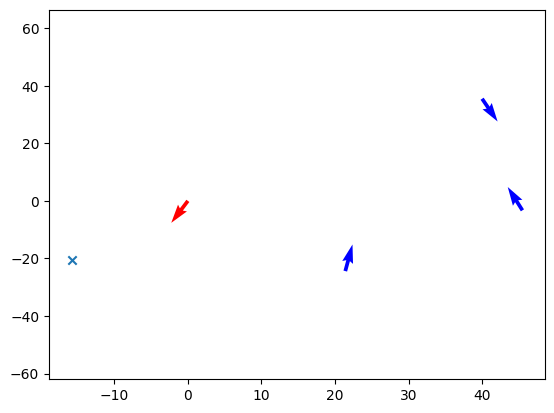

In [38]:
plt.quiver(0, 0, ego_vx, ego_vy, color='r')
plt.scatter(look_ahead_pt[0]-ego_pose[0], look_ahead_pt[1]-ego_pose[1], marker='x')

for obj in objs_pose:
    if obj[-1] == 0:
        continue
    plt.quiver(obj[0]-ego_pose[0], obj[1]-ego_pose[1], obj[3], obj[4], color='b')
    
plt.show()

## utm to bev

In [39]:
import numpy as np

def utm_to_bev(
        pt_utm_array: np.ndarray,
        ego_x_utm: float,
        ego_y_utm: float,
        ego_heading_utm: float
    ) -> np.ndarray:
    """Transform list of UTM points to BEV coordinate.

    Args:
        pt_utm_array (np.ndarray): List of UTM points. [[x, y, heading(Optional)]]
        ego_x_utm (float): Ego car x w.r.t. UTM
        ego_y_utm (float): Ego car y w.r.t. UTM
        ego_heading_utm (float): Ego car heading w.r.t. UTM

    Returns:
        np.ndarray: List of BEV points
    """
    
    def is_heading_provided() -> bool:
        return len(pt_utm_array[0]) > 2

    pt_bev_array = []
    for i in range(len(pt_utm_array)):
        pt_utm_x = pt_utm_array[i][0]
        pt_utm_y = pt_utm_array[i][1]

        pt_x_shifted = pt_utm_x - ego_x_utm
        pt_y_shifted = pt_utm_y - ego_y_utm

        pt_x_rotated = pt_x_shifted * np.cos(ego_heading_utm) \
                        + pt_y_shifted * np.sin(ego_heading_utm)
        pt_y_rotated = - pt_x_shifted * np.sin(ego_heading_utm) \
                        + pt_y_shifted * np.cos(ego_heading_utm)
        
        if is_heading_provided():
            pt_utm_heading = pt_utm_array[i][2]
            pt_heading_rotated = pt_utm_heading - ego_heading_utm
            pt_bev_array.append([pt_x_rotated, pt_y_rotated, pt_heading_rotated])
        else:
            pt_bev_array.append([pt_x_rotated, pt_y_rotated])

    pt_bev_array = np.asarray(pt_bev_array)
    return pt_bev_array

In [45]:
num_objs = 10

ego_bev = np.array([0, 0, 0])
objects_bev = utm_to_bev(objs_pose[0:num_objs,[0,1,2]], *ego_pose[0:3])
objects_v_bev = utm_to_bev(objs_pose[0:num_objs,[3, 4]], *ego_pose[0:3])

objects_v_bev = np.array([
    rotate_vec_2d(obj_v, -ego_pose[2]) for obj_v in objs_pose[0:num_objs,[3, 4]]
])
look_ahead_pt_bev = utm_to_bev([look_ahead_pt[:-1]], *ego_pose[0:3])

In [46]:
objects_bev

array([[ 6.65397513e+00,  3.17534883e+01, -2.98963835e-02],
       [ 9.28609538e+00,  3.31954879e+01,  3.51395657e+00],
       [-3.77847978e+01,  1.37405303e+01,  4.27183606e+00],
       [-4.19187477e+01,  4.19304533e+00,  4.32025341e+00],
       [ 1.87230714e+01,  3.90106279e+01,  3.95131408e+00],
       [-2.46770127e+01,  3.83280418e+01,  4.34591683e+00],
       [-4.57775106e+01,  3.13958087e+00,  4.33674379e+00],
       [-5.23896288e+01,  1.06575006e+01,  1.27319113e+00],
       [ 2.36693168e+01,  6.19779675e+01,  5.18473222e+00],
       [-6.58890881e+01, -1.31773976e+01,  2.72052932e-01]])

In [47]:
objects_v_bev

array([[-6.98062386e-03, -2.78278449e-03],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [-3.57745644e+00, -9.37269423e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.88716136e+00,  5.53197263e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])

In [48]:
look_ahead_pt_bev

array([[25.90361123, -0.32154375]])

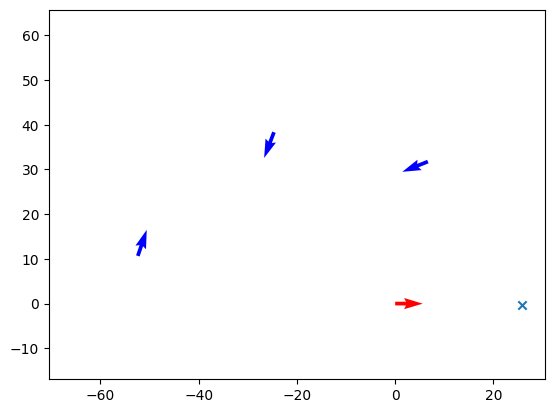

In [49]:
plt.quiver(ego_bev[0], ego_bev[1], ego_pose[3], ego_pose[4], color='r')
# plt.scatter(*objects_bev[:,:2], marker='x')
plt.scatter(*look_ahead_pt_bev[0], marker='x')
for idx in range(len(objects_bev)):
    plt.quiver(objects_bev[idx][0], objects_bev[idx][1], objects_v_bev[idx][0], objects_v_bev[idx][1], color='b')
    
plt.show()

In [50]:
def rotate_vec_2d(
    vec: np.ndarray,
    radian: float,
) -> np.ndarray:
    """ Rotate a 2D vector clockwise.

    Args:
        vec (np.ndarray): Query 2d vector.
        radian (float): Radian to rotate, in rad.

    Returns:
        np.ndarray: Result 2d vector.
    """

    rotation_matrix = np.array([
        [np.cos(radian), -np.sin(radian)],
        [np.sin(radian), np.cos(radian)]
    ])

    return np.matmul(rotation_matrix, vec)

In [51]:
query_vec = np.array([1,0])
rotated_vec = rotate_vec_2d(query_vec, -np.pi/4)

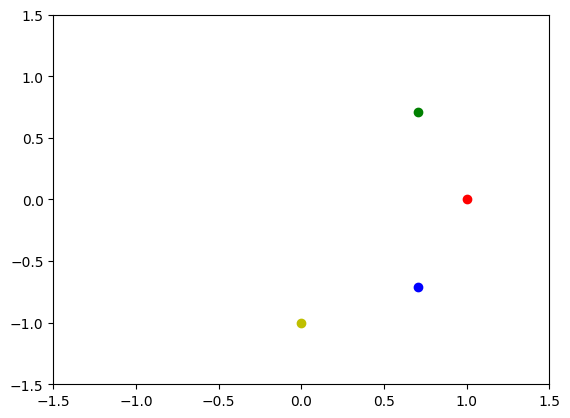

In [52]:
plt.scatter(*query_vec, color='r')
plt.scatter(*rotate_vec_2d(query_vec, 6*np.pi/4), color='y')
plt.scatter(*rotate_vec_2d(query_vec, np.pi/4), color='g')
plt.scatter(*rotate_vec_2d(query_vec, -np.pi/4), color='b')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.savefig('test.png', format='png')
plt.show()

In [53]:
def calculate_distance(
    query_point: np.ndarray,
    reference_point: np.ndarray
) -> float:
    """ Calculate distance between two points of any dimension.

    Args:
        query_point (np.ndarray): The query point.
        reference_point (np.ndarray): The reference point.

    Returns:
        float: distance
    """
    return np.linalg.norm(query_point-reference_point)

In [54]:
observation[0].shape

(11, 8)

In [55]:
selections = observation[0][:, -1].astype(bool)
selections

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [56]:
observation_filtered = observation[0][selections, :]
observation_filtered.shape

(11, 8)

In [57]:
observation[0]

array([[ 3.65016063e+05,  1.43861145e+05, -2.21501873e+00,
         6.67514409e+00, -2.54890318e-02,  5.70150500e-01,
         7.75198839e-02,  1.00000000e+00],
       [ 3.65037456e+05,  1.43836754e+05, -2.24491512e+00,
         1.96737861e-03,  7.25275260e-03,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65037028e+05,  1.43833783e+05,  1.29893784e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65049742e+05,  1.43883104e+05,  2.05681733e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65044591e+05,  1.43892143e+05,  2.10523468e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65036010e+05,  1.43822745e+05,  1.73629535e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65061529e+05,  1.438578

In [58]:
distance = np.array([calculate_distance(obj_loc, observation[0][0,0:2]) for obj_loc in observation[0][1:, 0:2]])
distance

array([32.44317191, 34.46987069, 40.20563541, 42.12793651, 43.27103522,
       45.58501666, 45.88504595, 53.46265543, 66.34383934, 67.19386685])

In [59]:
near_selections = distance <= 100
near_selections

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [60]:
def shuffle_objects(observation: np.ndarray) -> np.ndarray:
    return np.random.shuffle(observation[1:, :])

In [61]:
observation[0]

array([[ 3.65016063e+05,  1.43861145e+05, -2.21501873e+00,
         6.67514409e+00, -2.54890318e-02,  5.70150500e-01,
         7.75198839e-02,  1.00000000e+00],
       [ 3.65037456e+05,  1.43836754e+05, -2.24491512e+00,
         1.96737861e-03,  7.25275260e-03,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65037028e+05,  1.43833783e+05,  1.29893784e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65049742e+05,  1.43883104e+05,  2.05681733e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65044591e+05,  1.43892143e+05,  2.10523468e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65036010e+05,  1.43822745e+05,  1.73629535e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65061529e+05,  1.438578

In [62]:
shuffle_objects(observation[0])

In [63]:
observation[0]

array([[ 3.65016063e+05,  1.43861145e+05, -2.21501873e+00,
         6.67514409e+00, -2.54890318e-02,  5.70150500e-01,
         7.75198839e-02,  1.00000000e+00],
       [ 3.65061529e+05,  1.43857857e+05,  2.13089810e+00,
        -5.34555951e+00,  8.48943963e+00, -5.77160727e-07,
        -7.66450262e-07,  1.00000000e+00],
       [ 3.65049742e+05,  1.43883104e+05,  2.05681733e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65045098e+05,  1.43921741e+05, -1.94296580e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65037028e+05,  1.43833783e+05,  1.29893784e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65044591e+05,  1.43892143e+05,  2.10523468e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.65036010e+05,  1.438227